# Online linear regression using Kalman filtering

We perform sequential (recursive) Bayesian inference for the parameters of a linear regression model
using the Kalman filter. (This algorithm is also known as recursive least squares.)
To do this, we treat the parameters of the model as the unknown hidden states.
We assume that these are constant over time.
The graphical model is shown below.

![RLS](https://github.com/probml/dynamax/blob/main/docs/figures/rlsDgm.png?raw=true)

The model has the following form

\begin{align*}
\theta_t &=  \theta_{t-1}  \\
y_t &= x_t^T \theta_t + r_t, \; r_t \sim N(0, \sigma^2)
\end{align*}

This is a special case of LG-SSM with _time-varying_ emission weights,
\begin{align*} 
z_t &\sim \mathcal{N}(F z_{t-1}, Q) \\
y_t &\sim \mathcal{N}(H_t z_t, R)
\end{align*}
where the online parameter estimate $\theta_t$ corresponds to the latent state, $z_t$, the dynamics are deterministic ($F=I$, $Q=0$), the emission weights at time $t$ are the covariates $H_t = x_t^T$, and the emission covariance is $R = \sigma^2$.


## Setup

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install dynamax[notebooks]
    import dynamax

In [8]:
from jax import numpy as jnp
from jax import vmap
from matplotlib import pyplot as plt
from dynamax.linear_gaussian_ssm import LinearGaussianSSM

## Data

Data is from https://github.com/probml/pmtk3/blob/master/demos/linregOnlineDemoKalman.m


In [3]:
n_obs = 21
x = jnp.linspace(0, 20, n_obs)
X = jnp.column_stack((jnp.ones_like(x), x))  # Design matrix.
y = jnp.array(
    [2.486, -0.303, -4.053, -4.336, -6.174, -5.604, -3.507, -2.326, -4.638, -0.233, -1.986, 1.028, -2.264,
     -0.451, 1.167, 6.652, 4.145, 5.268, 6.34, 9.626, 14.784])

## Model

In [4]:
F = jnp.eye(2)
Q = jnp.zeros((2, 2))  # No parameter drift.
obs_var = 1.0
R = jnp.ones((1, 1)) * obs_var
mu0 = jnp.zeros(2)
Sigma0 = jnp.eye(2) * 10.0


# the input_dim = 0 since we encode the covariates into the non-stationary emission matrix
lgssm = LinearGaussianSSM(state_dim = 2, emission_dim = 1, input_dim = 0)
params, _ = lgssm.initialize(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_weights=F,
    dynamics_covariance=Q,
    emission_weights=X[:, None, :], # (t, 1, D) where D = num input features
    emission_covariance=R,
    )

## Online inference

Now use the Kalman filter to estimate the filtering distributions, which correspond to the online estimate of the weights after each data point is observed.

In [5]:
lgssm_posterior = lgssm.filter(params, y[:, None]) # reshape y to be (T,1)
kf_results = (lgssm_posterior.filtered_means, lgssm_posterior.filtered_covariances)

## Offline inference

For comparison, we compute the offline posterior given all the data using Bayes rule for linear regression.
This should give the same results as the final step of online inference.

In [6]:
posterior_prec = jnp.linalg.inv(Sigma0) + X.T @ X / obs_var
b = jnp.linalg.inv(Sigma0) @ mu0 + X.T @ y / obs_var
posterior_mean = jnp.linalg.solve(posterior_prec, b)
offline_results = (posterior_mean, posterior_prec)


## Plot results

Finally, plot the online estimates of the linear regression weights and the offline estimates to which they converge. The shading represnts the posterior standard deviation of the weights from the offline estimate. 

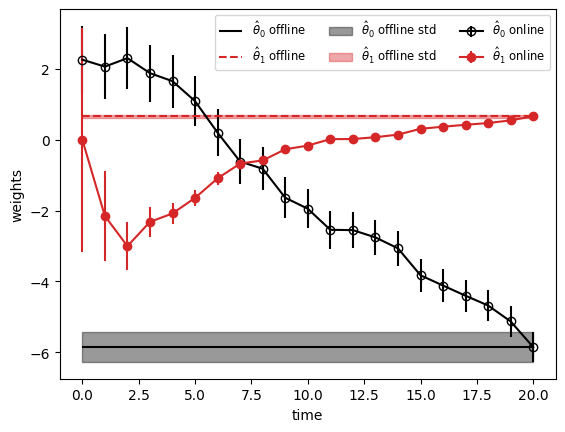

In [14]:
# Unpack kalman filter results
post_weights_kf, post_sigma_kf = kf_results
theta0_kf_hist, theta1_kf_hist = post_weights_kf.T
theta0_kf_err, theta1_kf_err = jnp.sqrt(vmap(jnp.diag)(post_sigma_kf)).T

# Unpack offline results
post_weights_offline, post_prec_offline = offline_results
theta0_post_offline, theta1_post_offline = post_weights_offline
Sigma_post_offline = jnp.linalg.inv(post_prec_offline)
theta0_std_offline, theta1_std_offline = jnp.sqrt(jnp.diag(Sigma_post_offline))

fig, ax = plt.subplots()
timesteps = jnp.arange(len(theta0_kf_hist))

# Plot online kalman filter posterior.
ax.errorbar(timesteps, theta0_kf_hist, theta0_kf_err, 
            fmt="-o", label=r"$\hat{\theta}_0$ online", color="black", fillstyle="none")
ax.errorbar(timesteps, theta1_kf_hist, theta1_kf_err, 
            fmt="-o", label=r"$\hat{\theta}_1$ online", color="tab:red")

# Plot offline posterior.
ax.hlines(y=theta0_post_offline, xmin=timesteps[0], xmax=timesteps[-1], 
          color="black", label=r"$\hat{\theta}_0$ offline")
ax.hlines(y=theta1_post_offline, xmin=timesteps[0], xmax=timesteps[-1], 
          color="tab:red", linestyle="--", label=r"$\hat{\theta}_1$ offline")
ax.fill_between(timesteps, theta0_post_offline - theta0_std_offline, theta0_post_offline + theta0_std_offline, 
                color="black", alpha=0.4, label=r"$\hat{\theta}_0$ offline std")
ax.fill_between(timesteps, theta1_post_offline - theta1_std_offline, theta1_post_offline + theta1_std_offline, 
                color="tab:red", alpha=0.4, label=r"$\hat{\theta}_1$ offline std")

ax.set_xlabel("time")
ax.set_ylabel("weights")
ax.legend(loc="upper right", ncol=3, fontsize="small")